Update: I'm abandoning this.  It is a futile exercise. 

# Introduction

This workbook clusters the results based on the value of the scores and maybe the range of scores. 

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Load data

In [2]:
df = pd.read_csv('results/results_clean_common.csv')

In [3]:
df['test_range'] = df.loc[:, 'max_test_score']-df.loc[:, 'min_test_score']

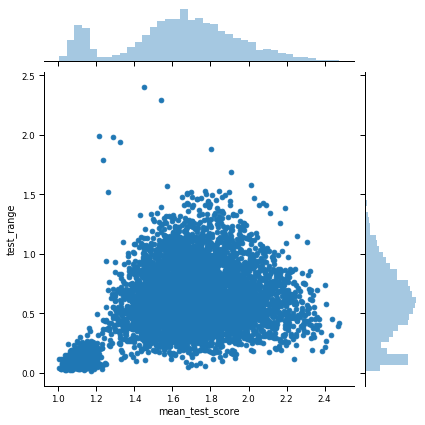

In [74]:
with sns.plotting_context('paper'):
    g = sns.jointplot(x="mean_test_score", y="test_range", data=df)

# DBSCAN 


We have uneven cluster size, and they're funny shapes so we can't really use KMeans, or a Gaussian mixture model. We'll use DBSCAN instead. This is based on reading Scikit learn documentation. https://scikit-learn.org/stable/modules/clustering.html

In [13]:
X = df.loc[:, ['mean_test_score', 'test_range']].values
X_scaled = StandardScaler().fit_transform(X)

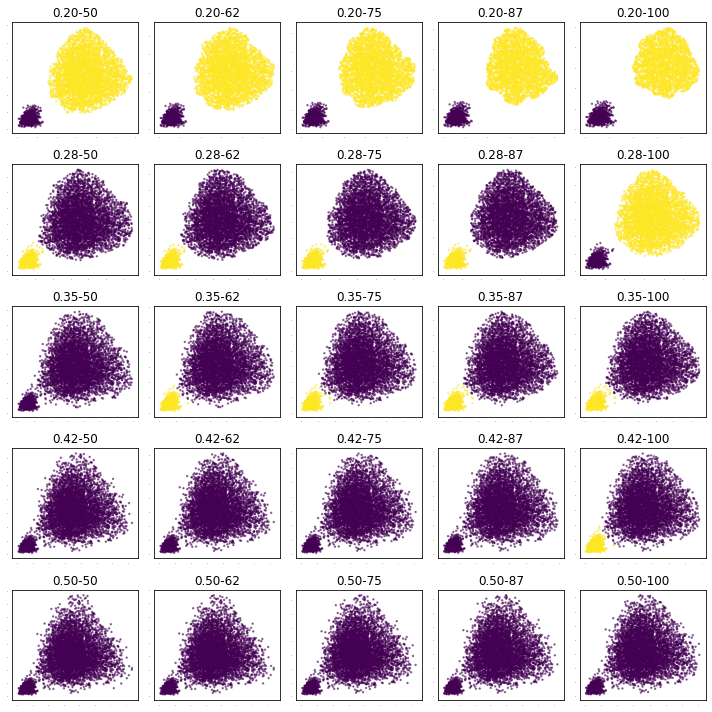

In [63]:
eps_values = np.linspace(0.2, 0.5, 5)
samp_values = np.linspace(50, 100, 5).astype(int)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, e in enumerate(eps_values):
    for j, s in enumerate(samp_values):
        db = DBSCAN(eps=e, min_samples=s).fit(X_scaled)
        idx = db.labels_>-1
        axes[i, j].scatter(X[idx, 0], X[idx, 1], c=db.labels_[idx], alpha=0.5,s=2)
        axes[i, j].set_title('{0:4.2f}-{1}'.format(e, s))
        axes[i, j].tick_params(which='both', axis='both', labelsize=0, length=0)
plt.tight_layout()


In [66]:
eps_values = np.linspace(0.2, 0.5, 20)
samp_values = np.linspace(50, 100, 20).astype(int)
dat = {'eps': [], 'min_values':[], 'silhouette':[], 'n_noise': []}

for i, e in enumerate(eps_values):
    for j, s in enumerate(samp_values):
        print((i, j), end=', ')
        db = DBSCAN(eps=e, min_samples=s).fit(X_scaled)
        idx = db.labels_>-1
        
        dat['eps'].append(e)
        dat['min_values'].append(s)
        dat['silhouette'].append(metrics.silhouette_score(X_scaled, db.labels_))
        dat['n_noise'].append(np.sum(idx))
        
        

(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17)

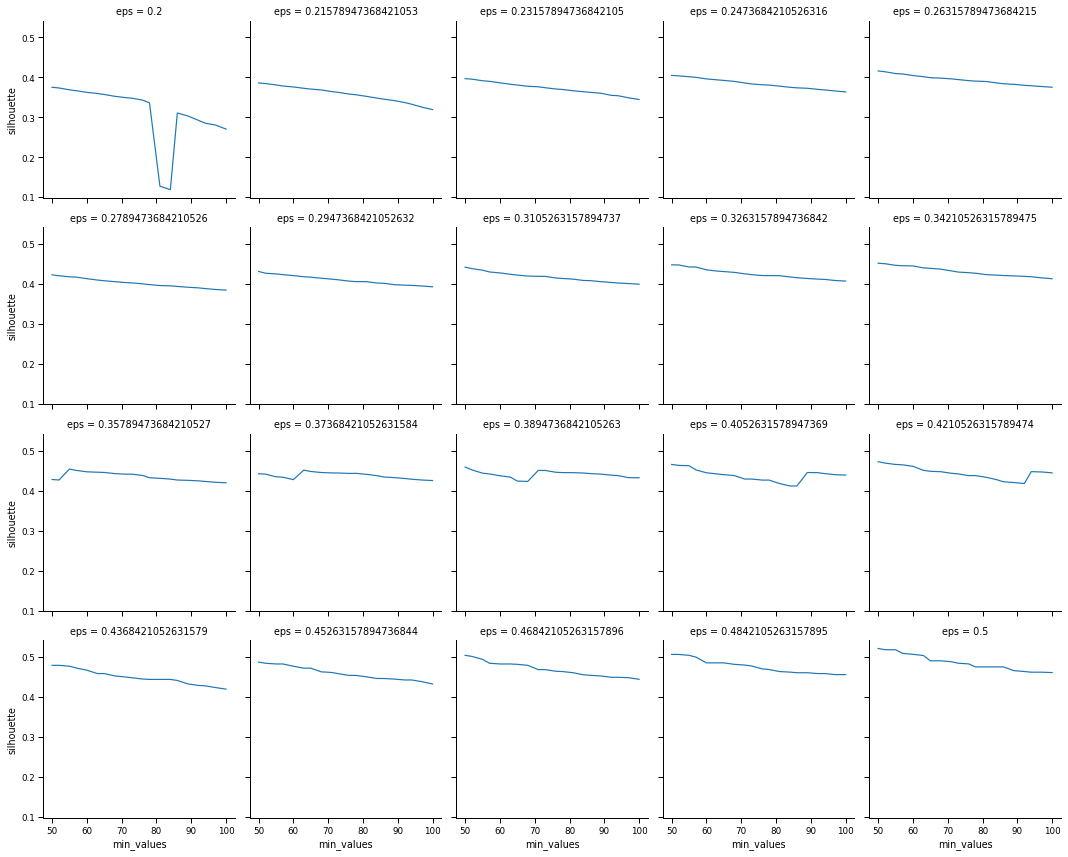

In [72]:
results = pd.DataFrame(dat)


with sns.plotting_context('paper'):
    g = sns.FacetGrid(results,  col='eps', col_wrap=5)
    g.map(plt.plot, 'min_values', 'silhouette')

This actually looks like a complicated mess. Low values of eps give me poor silhouette scores but they also give me the clusters I want. 

I'll do it in 1-D with a Gaussian Mixture model as this is just more obvious. 

# Gaussian Mixture

In [95]:
means_init=[[1.1], [1.8]]
weights_init=[np.sum(df['mean_test_score'] <1.3)/df.shape[0],np.sum(df['mean_test_score'] >1.3)/df.shape[0] ]


In [96]:
gmm = GaussianMixture(n_components=2, means_init= means_init,weights_init=weights_init )
gmm.fit(df['mean_test_score'].values.reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=array([[1.1],
       [1.8]]), n_components=2,
                n_init=1, precisions_init=None, random_state=None,
                reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
                warm_start=False, weights_init=array([0.15790428, 0.84209572]))

In [97]:
labels = gmm.predict(df['mean_test_score'].values.reshape(-1, 1))

In [103]:
x = np.linspace(1,3, 100)
y1 = gmm.covariances_

array([[[0.00161937]],

       [[0.05328679]]])

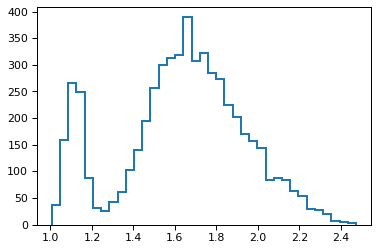

In [102]:
with sns.plotting_context('paper', font_scale=1.25):
    sns.distplot(X[:, 0], kde=False, hist=True, norm_hist=False, 
              hist_kws={'histtype': 'step', 'linewidth': 2, 'alpha': 1})